# ¿Cómo podemos predecir el sentimiento asociado con una interacción con el cliente?

In [10]:
!python3 -m pip install -q wordcloud nltk numpy pandas scikit-learn

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 30, 60

%matplotlib inline

**Fuente de datos**

Modelo de incrustciones pre entrenado: https://drive.google.com/file/d/1mM1Ane_aXy9iGVFTSfjq2etLwvoxqYOK/view?usp=sharing

Archivo de reviews: https://drive.google.com/file/d/1bXUCEsx9DbavsaH9iKFYPt3cRY3vVCdN/view?usp=sharing


## Introduccion

**Contexto comercial.** Eres un científico de datos para una gran empresa de comercio electrónico. Tienes decenas de miles de clientes que escriben reseñas sobre productos cada día. Cada revisión contiene comentarios textuales junto con un sistema de calificación de 1 a 5 estrellas (siendo 1 la menos satisfecha y 5 la más satisfecha). También tiene un equipo de atención al cliente que interactúa con los clientes a través de servicios de llamadas y mensajes. Su empresa también recopila comentarios sobre las experiencias de sus clientes con la interacción del sitio web después de cada compra. Ni este comentario ni el servicio de mensajería tienen un número de calificación. La empresa quiere cuantificar la satisfacción del cliente proveniente de estas interacciones no calificadas para ayudar con futuras decisiones comerciales (por ejemplo, determinar qué tan bien se están desempeñando sus diversos agentes de servicio al cliente).

**Problema comercial.** Su tarea es **construir modelos que puedan identificar el sentimiento (positivo o negativo) de cada una de estas interacciones no clasificadas**.

**Contexto analítico.** Los datos son un conjunto de reseñas en formato de archivo CSV. Combinaremos lo que aprendimos sobre el procesamiento de texto y los modelos de clasificación para desarrollar algoritmos capaces de clasificar las interacciones por sentimiento.

El caso está estructurado de la siguiente manera: 1) leeremos y analizaremos los datos del texto de entrada y las variables de respuesta correspondientes (calificaciones); 2) realizaremos un preprocesamiento básico para preparar los datos para el modelado; 3) aprenderemos y aplicaremos varias formas de caracterizar el texto de reseñas; y finalmente 4) construiremos modelos de aprendizaje automático para clasificar el texto como mostrando un sentimiento positivo o negativo (1 o 0).

## Leyendo la data


In [2]:
amazon_reviews = pd.read_csv('Reviews.csv')
## Elegimos solo los primeros 10000 por memoria
amazon_reviews = amazon_reviews[:10000]
## Cambiando los nombres de las columnas para que no tengan puntos (.)
#amazon_reviews.columns = [each.replace(".","_") for each in amazon_reviews.columns]

In [3]:
amazon_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
9995,9996,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ..."
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...


Veamos la distribución del número de palabras por reseña:

In [4]:
h= "Hola como estas soy yo"
#len(h.split(" "))
len(h.split(" "))

5

Text(0.5, 1.0, 'Distribucion palabras / comentario')

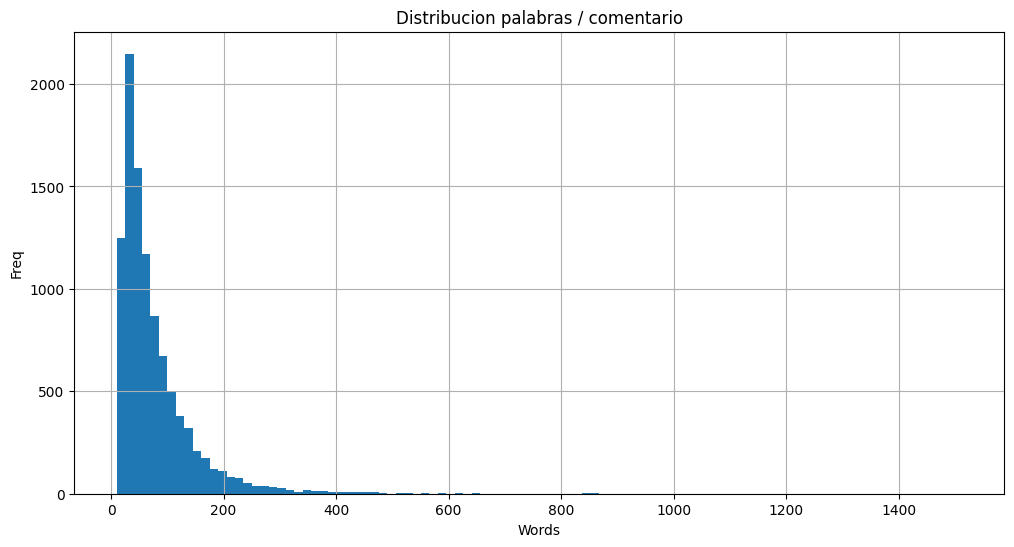

In [5]:
import matplotlib.pyplot as plt
words_per_review = amazon_reviews.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100,figsize=(12,6))
plt.xlabel('Words')
plt.ylabel('Freq')
plt.title('Distribucion palabras / comentario')

In [6]:
words_per_review.mean()

77.9028

Ahora miremos la distribucion de los ratings:

In [7]:
amazon_reviews.Score.value_counts()

Score
5    6183
4    1433
1     932
3     862
2     590
Name: count, dtype: int64

In [8]:
percent_val = 100 * amazon_reviews.Score.value_counts()/amazon_reviews.shape[0]
percent_val

Score
5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: count, dtype: float64

<Axes: xlabel='Score'>

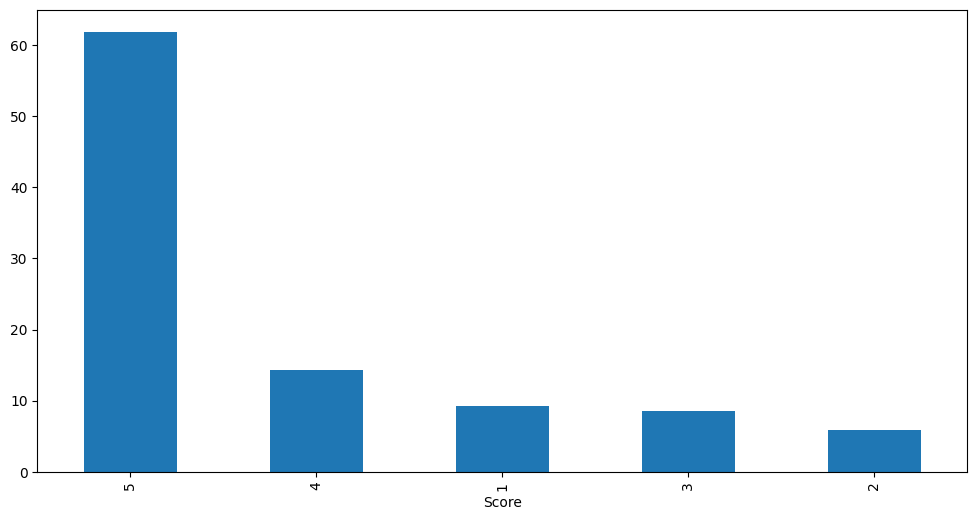

In [9]:
percent_val.plot.bar(figsize=(12,6))

La distribución es bastante sesgada, con un gran número de 5 y muy pocos 3, 2 y 1.

### Ejercicio 1

Cree una nube de palabras para las reseñas de productos.

In [10]:
amazon_reviews.query("Score==1").Text

1       Product arrived labeled as Jumbo Salted Peanut...
12      My cats have been happily eating Felidae Plati...
26      The candy is just red , No flavor . Just  plan...
50      This oatmeal is not good. Its mushy, soft, I d...
62      Arrived in 6 days and were so stale i could no...
                              ...                        
9937    I bought Nutiva organic chia seeds before, two...
9971    I love the Nativa brand, however, they always ...
9972    I bought this product not that many months ago...
9985    You think you're doing something good for your...
9995    we switched from the advance similac to the or...
Name: Text, Length: 932, dtype: object

436877


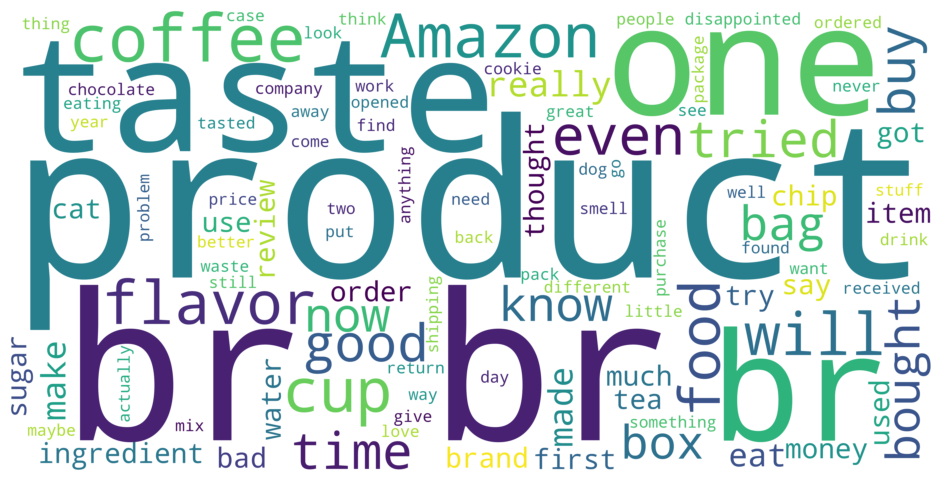

In [11]:
word_cloud_text = ''.join(amazon_reviews.query("Score==1").Text)
print(len(word_cloud_text))
word_cloud_text
wordcloud = WordCloud(max_font_size=200, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate(word_cloud_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

4157740


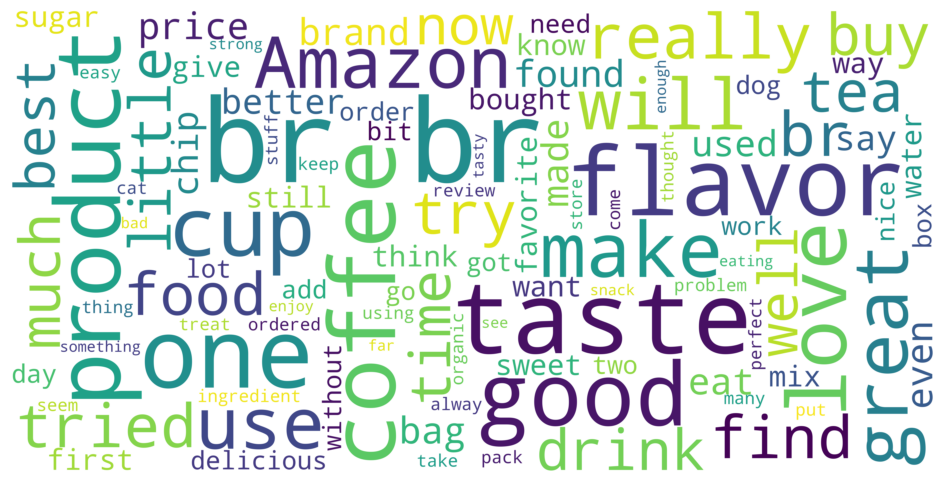

In [12]:
word_cloud_text = ''.join(amazon_reviews.Text[0:10000])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate(word_cloud_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

La nube de palabras indica que muchas de las reseñas hablan de cosas relacionadas con la comida: café, sabor, comida, sabor, bebida. También vemos algunas palabras positivas como bueno, amor, mejor.

### Estandarización de ratings para análisis de sentimiento

Para fines de análisis de sentimiento, convertiremos todas las calificaciones en valores binarios utilizando la siguiente regla: las calificaciones de 4 o 5 se asignarán a 1, las calificaciones de 1 o 2 se asignarán a 0 y las calificaciones de 3 se dejaran por fuera.

In [13]:
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3,1,0)
amazon_reviews['Sentiment_rating'].value_counts()

Sentiment_rating
1    7616
0    2384
Name: count, dtype: int64

In [14]:
##Removiendo la categoria neutral por ahora
amazon_reviews = amazon_reviews[amazon_reviews['Score'] != 3]

<Axes: xlabel='Sentiment_rating'>

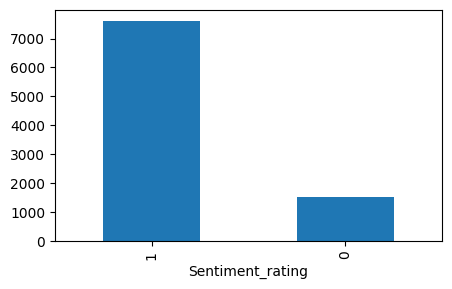

In [15]:
rcParams['figure.figsize'] = 5, 3
#plt.figure(figsize=(12,6))
amazon_reviews.Sentiment_rating.value_counts().plot.bar()

In [16]:
amazon_reviews[['Text','Sentiment_rating']]

,Text,Sentiment_rating
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
...,...,...
9995,we switched from the advance similac to the or...,0
9996,"Like the bad reviews say, the organic formula ...",1
9997,I wanted to solely breastfeed but was unable t...,1
9998,i love the fact that i can get this delieved t...,1


## Pre-procesamiento

Como se discutió anteriormente, el preprocesamiento y la normalización del texto son cruciales antes de construir un modelo NLP adecuado. Algunos de los pasos importantes son:

1. convertir palabras a minúsculas/mayúsculas
2. eliminar caracteres especiales
3. eliminar palabras vacías y palabras de alta/baja frecuencia
4. Stemming/lematización

Procedamos en orden. Comencemos convirtiendo todas las palabras en un formato de mayúsculas y minúsculas consistente, digamos en minúsculas:

In [17]:
amazon_reviews['reviews_text_new'] = amazon_reviews.Text.apply(lambda x: x.lower())

In [18]:
nltk.download("punkt") # Descargar signos de puntacion

[nltk_data] Downloading package punkt to /Users/davidusta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/davidusta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
from nltk import word_tokenize, sent_tokenize
word_tokenize('Hola como estas, estoy esperando: 1.')
#sent_tokenize("Hola como estas. Bien y tu. ")

['Hola', 'como', 'estas', ',', 'estoy', 'esperando', ':', '1', '.']

In [31]:
token_lists= [['I','love','you'], ['I', 'hate','you']]
set([item for sublist in token_lists for item in sublist])

{'I', 'hate', 'love', 'you'}

In [21]:
from nltk import word_tokenize

token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ",len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de token unicos ahora: ",len(set(tokens_lower)))

Numero de tokens unicos antes:  27509
Numero de token unicos ahora:  22473


In [22]:
(27510-22474)/22474*100

22.408116045207795

La cantidad de tokens se ha reducido en ~22% solo por normalizar el caso.

### Ejercicio 2

¿Es la eliminación de caracteres especiales incluso una buena idea? ¿Cuáles son algunos ejemplos de caracteres que probablemente sería seguro eliminar y cuáles no?

**Respuesta.** Eliminar caracteres especiales es una decisión subjetiva, especialmente en casos como este. Las personas a menudo usan caracteres especiales para expresar sus emociones y pueden dejar una reseña como _'¡Este producto es el peor!'_, mientras que una reseña positiva podría ser _'¡Este producto es el mejor! ¡Me encantó!'_ Aquí, la presencia de signos de exclamación indica claramente algo sobre el sentimiento subyacente, por lo que eliminarlos puede no ser una buena idea.

Por otro lado, eliminar la puntuación sin carga emocional, como las comas, los puntos y el punto y coma, probablemente sea seguro.

En aras de la simplicidad, procederemos eliminando todos los caracteres especiales; sin embargo, vale la pena tener en cuenta que esto es algo para revisar dependiendo de los resultados que obtengamos más adelante. Lo siguiente da una lista de todos los caracteres especiales en nuestro conjunto de datos:

In [23]:
x= 'david12233'
x.isalnum()

True

In [24]:
spl_chars = amazon_reviews.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])
spl_chars

0                                               [., ., .]
1                                   [., ., ., ., ", ", .]
2       [., ,, -, ., ., ., ,, ., ., ., ., ', ", ,, ,, ...
3                                         [., (, ), ., .]
4                                         [., ., ., ,, .]
                              ...                        
9995                                            [., ., .]
9996    [,, ., ,, (, -, ), ., ', ., ', ,, ,, ., <, /, ...
9997    [., ., ., ., ., ., ., ,, ., ., ,, ,, (, ), ., ...
9998                                                  [.]
9999    [., ., ., ., ., ., ', ,, ., <, /, >, ., ,, ., ...
Name: reviews_text_new, Length: 9138, dtype: object

In [25]:
lista_vacia=[]
for i in spl_chars:
    for j in i:
        lista_vacia.append(j)
print(set(lista_vacia))

{')', '=', '[', '(', '$', '@', '}', '?', '{', '+', '!', '®', '§', '>', ':', '*', ';', ']', '&', '%', '^', '~', "'", '_', '"', '/', '<', '-', '#', ',', '`', '.'}


In [26]:
### Seleccionar caracteres no alfanuméricos que no sean espacios
spl_chars = amazon_reviews.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

## Obteniendo todo en una lista
flat_list = [item for sublist in spl_chars for item in sublist]

## Caracteres especiales unicos
print(len(flat_list))
print(len(set(flat_list)))
print(set(flat_list))

148403
32
{')', '=', '[', '(', '$', '@', '}', '?', '{', '+', '!', '®', '§', '>', ':', '*', ';', ']', '&', '%', '^', '~', "'", '_', '"', '/', '<', '-', '#', ',', '`', '.'}


Eliminemos estos caracteres especiales de las reseñas:

In [27]:
import re
review_backup = amazon_reviews.reviews_text_new.copy()
amazon_reviews.reviews_text_new = amazon_reviews.reviews_text_new.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

Podemos ver cómo cambian nuestras reseñas después de eliminar estas:

In [28]:
print("Old Review:")
review_backup.values[5]

Old Review:


'i got a wild hair for taffy and ordered this five pound bag. the taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. my only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). between me, my kids, and my husband, this lasted only two weeks! i would recommend this brand of taffy -- it was a delightful treat.'

In [29]:
print("New Review:")
amazon_reviews.reviews_text_new[5]

New Review:


'i got a wild hair for taffy and ordered this five pound bag  the taffy was all very enjoyable with many flavors  watermelon  root beer  melon  peppermint  grape  etc  my only complaint is there was a bit too much red black licorice flavored pieces  just not my particular favorites  between me  my kids  and my husband  this lasted only two weeks  i would recommend this brand of taffy   it was a delightful treat '

El número de tokens únicos se ha reducido aún más:

In [30]:
token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos despues: ",len(set(tokens)))

Numero de token unicos antes:  27509
Numero de token unicos despues:  18039


In [31]:
((27509-18039)/27509)*100

34.42509724090298

### Stopwords y palabras de alta/baja frecuencia

Como se discutió anteriormente, las palabras vacías ocurren naturalmente con mucha frecuencia en el idioma inglés sin agregar ninguna idea específica del contexto. Tiene sentido eliminarlos:

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidusta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
stopwords_corpus = nltk.corpus.stopwords
print(len(stopwords_corpus.words('english')))
print(stopwords_corpus.words('english'))

198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 

In [36]:
noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
noise_words[0:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [37]:
len(noise_words)

198

### Ejercicio 3

Encuentre las palabras de alta y baja frecuencia, que definiremos como el 1 % de las palabras que aparecen con más frecuencia en las reseñas, así como definir el 1 % de las palabras que aparecen con menos frecuencia en las reseñas (después de ajustar por mayúsculas y minúsculas). caracteres especiales).

In [38]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:20]

[('the', 28122),
 ('i', 25705),
 ('and', 19980),
 ('a', 18505),
 ('it', 16143),
 ('to', 15137),
 ('of', 12067),
 ('is', 11063),
 ('this', 10530),
 ('br', 9361),
 ('for', 8233),
 ('in', 7940),
 ('my', 6786),
 ('that', 6494),
 ('you', 5662),
 ('with', 5605),
 ('but', 5450),
 ('have', 5292),
 ('not', 5106),
 ('are', 4919)]

In [39]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:20]

[('pruchase', 1),
 ('slick', 1),
 ('cloured', 1),
 ('innocuous', 1),
 ('espensive', 1),
 ('marketer', 1),
 ('strofoam', 1),
 ('destroyers', 1),
 ('ruth', 1),
 ('gleaning', 1),
 ('fantasies', 1),
 ('unexpexctedly', 1),
 ('emporium', 1),
 ('calmatives', 1),
 ('relievers', 1),
 ('custumers', 1),
 ('molases', 1),
 ('0303', 1),
 ('explination', 1),
 ('ethel', 1)]

In [40]:
len(noise_words)

198

In [41]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [44]:
len(list(set(noise_words)))

472

Ahora se han agregado palabras vacías y palabras de alta/baja frecuencia a `noise_words`, que se eliminarán de las revisiones antes de entrenar modelos de aprendizaje automático.

### Stemming & lemmatizacion

Ahora estamos listos para la última parte de nuestro procesamiento previo: **lematización y stemming**.

Las diferentes formas de una palabra a menudo comunican esencialmente el mismo significado. Por ejemplo, probablemente no haya diferencia en la intención entre una búsqueda de "zapato" y una búsqueda de "zapatos". La misma palabra también puede aparecer en diferentes tiempos; p.ej. "correr", "corres" y "corriendo". Estas diferencias sintácticas entre las formas de las palabras se llaman **inflexiones**. En general, probablemente queramos tratar las inflexiones de manera idéntica cuando destacamos nuestro texto.

A veces, este proceso es casi reversible y bastante seguro (por ejemplo, reemplazar los verbos con su infinitivo, de modo que "run", "runs" y "running" se conviertan en "run"). Otras veces es un poco peligroso y depende del contexto (por ejemplo, reemplazar los superlativos con su forma base, de modo que "bueno", "mejor" y "mejor" se conviertan en "bueno"). Cuanto más agresivo sea, mayores serán las posibles recompensas y riesgos. Para un ejemplo muy agresivo, puede elegir reemplazar "Zeus" y "Júpiter" solo con "Zeus"; esto podría estar bien si está resumiendo mitos, confuso si está trabajando en astronomía y desastroso si está trabajando en mitología comparada.

No entraremos en los detalles de las diferencias entre lematización, stemming y otros tipos de normalización de texto aquí, pero se puede encontrar una introducción cuidadosa en: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.



In [45]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidusta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Algoritmos de Stemming** trabajan cortando el final o el principio de la palabra, teniendo en cuenta una lista de prefijos y sufijos comunes que se pueden encontrar.

Por otro lado, la **lematización** toma en consideración el análisis morfológico de las palabras. Por lo tanto, la lematización tiene en cuenta la gramática de la palabra e intenta encontrar la palabra raíz en lugar de simplemente llegar a la palabra raíz mediante métodos de fuerza bruta.

In [47]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

Lancaster Stemmer
troubl
troubl
troubl


In [48]:
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))
print(lemmatizer.lemmatize("trouble"))

WordNet Lemmatizer
trouble
trouble
trouble
trouble


Se puede ver que obtenemos una raíz de significado de Lemmatizer, mientras que Stemmer simplemente recorta y extrae la primera parte importante de la palabra.

## Creando el modelo ML

Ahora tenemos versiones limpias de dos datos muy importantes: el texto de revisión real y su calificación de sentimiento correspondiente:

In [49]:
amazon_reviews[['Text','Score','Sentiment_rating','reviews_text_new']].head(5)

,Text,Score,Sentiment_rating,reviews_text_new
0,I have bought several of the Vitality canned d...,5,1,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,1,0,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,4,1,this is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,2,0,if you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,5,1,great taffy at a great price there was a wid...


Las variables independientes o características del modelo se derivan del texto de revisión. Previamente, discutimos cómo podemos usar n-gramas para crear características, y específicamente cómo la bolsa de palabras es la interpretación más simple de estos n-gramas, sin tener en cuenta el orden y el contexto por completo y solo enfocándonos en la frecuencia/recuento. Usemos eso como punto de partida.

The dog is playing

**1-grams>**
The, dog, is, playing

**2 grams>**
The dog, god is, is playing

**3-grams>**
The dog is, dig is playing

**4-grams>**
The dog is playing

### Bag-of-words
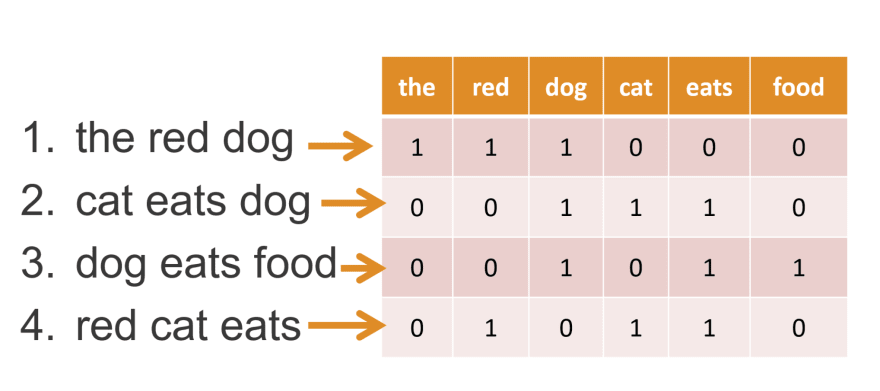

`CountVectorizer` es una clase de Python que da cuenta automáticamente de ciertos pasos de preprocesamiento, como la eliminación de palabras vacías, la stemming, la creación de n-gramas y la tokenización de palabras:

In [45]:
### Creando el metodo para stemming
"""
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))
"""

'\nfrom nltk.stem import PorterStemmer\nstemmer = PorterStemmer()\nanalyzer = CountVectorizer().build_analyzer()\n\ndef stemmed_words(doc):\n    return (stemmer.stem(w) for w in analyzer(doc))\n'

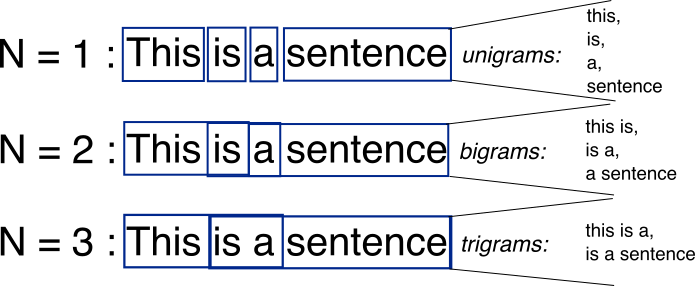

Usemos esto para crear una bolsa de palabras de las reseñas, excluyendo las palabras irrelevantes que identificamos anteriormente:

"Hi how are you"
- n = 1 Hi, how, are , you (Unigrams)
- n= 2, Hi how, how are, are you (bigramas)
- n= 3, Hi how are, how are you (trigramas)

In [50]:
print(noise_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [51]:
###Creando un objeto python de la clase CountVectorizer
bow_counts = CountVectorizer(tokenizer= word_tokenize, stop_words=noise_words,ngram_range=(1,1))
bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

In [52]:
type(bow_data)

scipy.sparse._csr.csr_matrix

In [53]:
bow_data

<9138x17616 sparse matrix of type '<class 'numpy.int64'>'
	with 218332 stored elements in Compressed Sparse Row format>

Una vez que se prepara la bolsa de palabras, el conjunto de datos debe dividirse en conjuntos de entrenamiento y prueba:

In [54]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow =  \
                            train_test_split(bow_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 42)

In [55]:
y_test_bow.value_counts()/y_test_bow.shape[0]

Sentiment_rating
1    0.845733
0    0.154267
Name: count, dtype: float64

In [56]:
y_train_bow.value_counts()/y_train_bow.shape[0]

Sentiment_rating
1    0.830369
0    0.169631
Name: count, dtype: float64

Los datos de prueba contienen 84% de opiniones positivas. Entonces, si tuviéramos que clasificar ingenuamente todas las reseñas como positivas, nuestro modelo lograría una precisión del 84 %. Por lo tanto, esta es la línea de base que debe superar cualquier modelo que creemos.

### Modelo de regresion logistica

Entrenemos el modelo en nuestros datos de entrenamiento y ejecutemos el modelo resultante en nuestros datos de prueba:

In [57]:
### Entrenando el modelo
lr_model_all = LogisticRegression(C = 1)
lr_model_all.fit(X_train_bow,y_train_bow)

LogisticRegression(C=1)

In [58]:
## Prediccion
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9363177805800756
Accuracy:  88.94967177242889


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test_bow, y_pred=test_pred_lr_all))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58       282
           1       0.91      0.96      0.94      1546

    accuracy                           0.89      1828
   macro avg       0.81      0.73      0.76      1828
weighted avg       0.88      0.89      0.88      1828



In [61]:
prob = [each[1] for each in test_pred_lr_prob]
prob[0:5]

[0.9621352757843258,
 0.27626550465297933,
 0.9943288283830884,
 0.9059859461677161,
 0.9395458810580922]

In [62]:
X_test_bow.indices

array([14326,  4617, 11450, ...,   240,  1892,  7112], dtype=int32)

In [63]:
prob = [each[1] for each in test_pred_lr_prob]

predictions = pd.DataFrame(list(zip(amazon_reviews[amazon_reviews.index.isin(X_test_bow.indices)].Text.values,
                             amazon_reviews[amazon_reviews.index.isin(X_test_bow.indices)].Score.values,
                             test_pred_lr_all,
                             prob)),
                            columns = ['Review','Actual_Score','Predicted_Sentiment','Predicted_probability'])

In [64]:
predictions.tail(15)

,Review,Actual_Score,Predicted_Sentiment,Predicted_probability
1813,Just in case you don't know - these are about ...,4,1,0.958821
1814,"Reading other reviews, I was excited to try th...",2,1,0.905895
1815,A great idea that falls short. Bisquick gluten...,1,1,0.983291
1816,Our family has tried just about every gluten-f...,5,1,0.974219
1817,I bought this on a whim because I was craving ...,5,1,0.963786
1818,I have used Bisquick forever and now that I ha...,5,0,0.139609
1819,"This mix is great for biscuits, snicker doodle...",5,1,0.999448
1820,I have been Gluten Free Since 2003 and this is...,1,1,0.762061
1821,Now if you could just make it sugar-free also?...,2,1,0.989052
1822,Ok--I just bought BIsquick GF and the first th...,4,1,0.983239


### Ejercicio 4

Mire las tres revisiones para las que el modelo predijo las puntuaciones más bajas y vea si se pronosticaron correctamente. Si no, explique por qué se pronosticaron incorrectamente.

In [71]:
predictions.sort_values(['Predicted_probability'], ascending = True)[:3].values

array([["I tried this gum after Trident cinnamon became hard to find a couple of years ago.  (Trident told me that they were overhauling the plant that made the gum so it was in short supply but it would be back.)  I quickly discovered that the Flare 5 was far superior to the Trident and I haven't looked back.  It does last a long, long, long, time.  Unfortunatley, as other reviewers noted, it has become very hard to find in stores.  Trident cinnamon is everywhere but now I don't want it.  Amazon saves the day again.",
        5, 0, 4.671341404295806e-13],
       ['i have ordered mackerel several times on amazon and most pleased with SEASONS brand than any other. seems to me the fish are smaller therefore less mercury.<br />packed in olive oil is also a bonus. they are not as "fishy" as others that i have tried. i eat them to get a healthy serving of omega 3. my 11 year old boy has taken a liking for them as well as my 14 year old daughter. we put a small chunk on a cracker and top wit

In [72]:
predictions.sort_values(['Predicted_probability'], ascending = False)[:3].values

array([['We love strawberries dipped in chocolate but locally we could not find the dark chocolate type - so glad we found this at Amazon - it is WONDERFUL!',
        5, 1, 0.9999999999996303],
       ["I tried to find the ingredients for this hot cocoa before I bought it, but couldn't find anything online. Turns out it has one of those mile long ingredient lists, and yet, that didn't help the taste at all. It is awful.<br /><br />I had three boxes of the stuff sitting around for a month and couldn't find any takers. I finally got rid it of it at the Christmas White Elephant gift exchange at work. I put it with a nice cookbook, which was the real present, and wrapped it real prettily. Unfortunately, the boss ended up with it. I haven't asked him if his family enjoyed it because I don't want to put him on the spot. Judging by the reviews, there are a lot of people who like it - hopefully, he will, too. Maybe it just depends on how your taste buds are trained. Mine grew up with hot choco

La primera y la tercera revisión se predijeron incorrectamente. No está claro por qué la primera reseña obtuvo una mala puntuación (no hay palabras negativas obvias allí), pero la tercera reseña tiene varias palabras negativas como "no son", "no", "falta", "negativo". ", a pesar de que en contexto estas palabras no significan mucho. Claramente, presentar nuestro texto con 1-grams no puede capturar el contexto general de las reseñas.

### Ejercicio 5

Modifique el conjunto de características en el modelo para incluir bigramas, trigramas y 4-gramas. No elimine las palabras irrelevantes definidas anteriormente antes de presentarlas. (Ayuda: pon `ngram_range=(1,4)`.)

In [65]:
### Cambios con respecto al código anterior
### 1. Aumentar los n-gramas de solo tener 1 gramo a (1 gramo, 2 gramos, 3 gramos y 4 gramos)
### 2. Incluir las palabras vacías en la bolsa de características de las palabras

bow_counts = CountVectorizer(tokenizer= word_tokenize,stop_words=noise_words,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

In [66]:
# Observe el aumento de funciones con la inclusión de palabras vacías
bow_data

<9138x631193 sparse matrix of type '<class 'numpy.int64'>'
	with 904584 stored elements in Compressed Sparse Row format>

In [67]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow =  \
                            train_test_split(bow_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

In [68]:
### Cambios en la regresión logística
### Cambiando el parámetro de costo C para que sea 0.9
lr_model_all_new = LogisticRegression(C = 0.9, penalty= 'l2')

In [69]:
# entrenamiento del model
lr_model_all_new.fit(X_train_bow,y_train_bow)

# Prediccion del output
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9418640418332821
Accuracy:  89.66083150984683


In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_bow, y_pred=test_pred_lr_all))

              precision    recall  f1-score   support

           0       0.85      0.39      0.53       278
           1       0.90      0.99      0.94      1550

    accuracy                           0.90      1828
   macro avg       0.88      0.69      0.74      1828
weighted avg       0.89      0.90      0.88      1828



La precisión ha saltado del 90% al 91,8%. Este es un ejemplo de lo que el simple ajuste de hiperparámetros y la modificación de características de entrada pueden hacer en el rendimiento general. Incluso podemos obtener características interpretables de esto en términos de lo que más contribuyó al sentimiento positivo y negativo:

In [71]:
bow_counts.get_feature_names_out()

array(['0', '0 16', '0 16 vitamin', ..., 'zuppa engelesia',
       'zuppa engelesia mixed', 'zuppa engelesia mixed cream'],
      dtype=object)

In [72]:
bow_counts.get_feature_names_out()[0:100]

array(['0', '0 16', '0 16 vitamin', '0 16 vitamin e', '0 19',
       '0 19 selenium', '0 19 selenium se', '0 1g', '0 1g scale',
       '0 1g scale caviar', '0 26', '0 26 mins', '0 26 mins span', '0 29',
       '0 29 cents', '0 29 cents ounce', '0 2g', '0 2g cholesterol',
       '0 2g cholesterol 15mg', '0 30', '0 30 cents', '0 30 cents per',
       '0 32', '0 32 mins', '0 32 mins span', '0 35', '0 35 oz',
       '0 35 oz stevia', '0 38', '0 38 probably', '0 38 probably full',
       '0 44', '0 44 baked', '0 44 baked kettles', '0 5', '0 5 cortisone',
       '0 5 cortisone pepcid', '0 5 grams', '0 5 grams salted',
       '0 5 short', '0 5 short seal', '0 5 sodium', '0 5 sodium 70mg',
       '0 5 stars', '0 5 stars read', '0 5g', '0 5g 4', '0 5g 4 trans',
       '0 75', '0 75 per', '0 75 per 8', '0 75 per expect', '0 8',
       '0 8 g', '0 8 g protein', '0 8 ounce', '0 8 ounce single',
       '0 8 ounces', '0 8 ounces compared', '0 8 oz', '0 8 oz 21',
       '0 8 oz anymore', '0 8 oz bags

In [190]:
lr_model_all_new.coef_

array([[-0.07846678,  0.00371776,  0.00371776, ...,  0.00534   ,
         0.00534   ,  0.00534   ]])

In [73]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names_out(),
                                   lr_model_all_new.coef_[0])),
                          columns= ['words','weights'])

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
193789,excellent,1.196548
511228,smooth,1.152498
328711,loves,1.093977
266962,highly,0.988702
512191,snack,0.979584
30927,amazing,0.946871
618495,wonderful,0.930715
256450,happy,0.830852
205628,fast,0.792221
225139,fresh,0.750955


In [75]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
45674,away,-0.953791
283307,ingredient,-0.967014
338558,maybe,-0.982828
532650,stick,-0.993213
561988,terrible,-1.010893
569316,thought,-1.034662
50550,bad,-1.086717
463366,return,-1.168072
607532,waste,-1.202956
46889,awful,-1.238189


### Ejercicio 6

Realice una clasificación de Random Forest en nuestro conjunto de características tal como lo hicimos anteriormente con la regresión logística.

**Se demora como 10 min (OJO!!!)**

In [84]:
rf_model_all = RandomForestClassifier()

### Ajustando el modelo
rf_model_all.fit(X_train_bow,y_train_bow)

### Una vez que se ajusta el modelo, se predice la salida para los datos de validación cruzada
test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)

In [85]:
print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.928335832083958
Accuracy:  86.92560175054705


Esto no es tan bueno como la regresión logística. Podemos obtener los n-gramas que fueron más importantes para las predicciones de la siguiente manera:

In [86]:
feature_importances = pd.DataFrame(rf_model_all.feature_importances_,
                                   index = bow_counts.get_feature_names_out(),
                                    columns=['importance'])

In [87]:
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
disappointed,0.004388
worst,0.004146
return,0.003369
waste,0.003022
awful,0.002934
horrible,0.002755
disappointing,0.002750
waste money,0.002529
refund,0.002401
bad,0.002383


## TF-IDF model

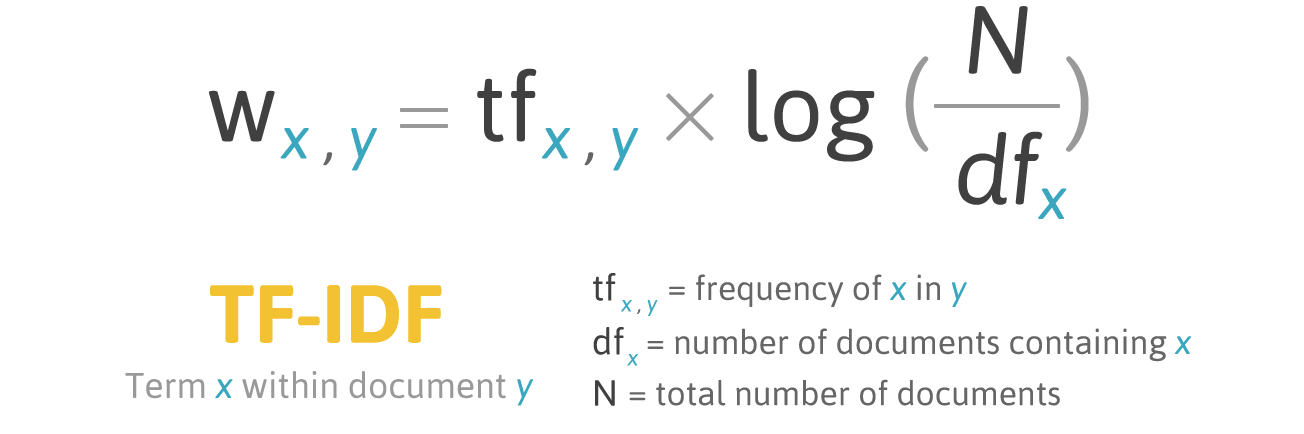

Por supuesto, BoW no es la única forma de caracterizar el texto. Otro método, que mencionamos brevemente antes, es el método **Término de frecuencia-frecuencia inversa del documento (TF-IDF)**. Esto evalúa qué tan importante es una palabra para un documento dentro de una gran colección de documentos (es decir, corpus). La importancia aumenta proporcionalmente en función del número de veces que aparece una palabra en el documento, pero se compensa con la frecuencia de la palabra en el corpus.

El peso TF-IDF es el producto de dos términos. El primero calcula la frecuencia de término normalizada (TF); es decir, el número de veces que aparece una palabra en un documento dividido por el número total de palabras en ese documento. El segundo término es la Frecuencia Inversa de Documentos (IDF), calculada como el logaritmo del número de documentos en el corpus dividido por el número de documentos donde aparece el término específico:

Volvamos a presentar nuestro conjunto original de revisiones basado en TF-IDF y dividamos las funciones resultantes en conjuntos de entrenamiento y prueba:

In [76]:
### Instanciando el objeto
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,stop_words=noise_words,
                             ngram_range=(1,1))
tfidf_data = tfidf_counts.fit_transform(amazon_reviews.reviews_text_new)

In [77]:
tfidf_data.data

array([0.18975855, 0.38644788, 0.23334488, ..., 0.14883946, 0.13930284,
       0.14192978])

In [78]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf =  \
                            train_test_split(tfidf_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

In [79]:
X_train_tfidf.shape

(7310, 17616)

### Aplicación de regresión logística a características TF-IDF

Aplicaremos el modelo de RL usando la TF-IDF:

In [80]:
### Definiendo el modelo
lr_model_tf_idf = LogisticRegression()

## Entrenando el modelo
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciendo los resultados
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluando el modelo
print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9338168631006346
Accuracy:  88.01969365426696


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_tfidf, y_pred=test_pred_lr_all))

              precision    recall  f1-score   support

           0       0.93      0.23      0.37       278
           1       0.88      1.00      0.93      1550

    accuracy                           0.88      1828
   macro avg       0.90      0.61      0.65      1828
weighted avg       0.89      0.88      0.85      1828



Incrementamos el accuracy con la TF-IDF comparando los resultados de BoW

### Ejercicio 7

Intente aumentar la precisión del modelo configurando `ngram_range=(1,4)` y no eliminando las palabras irrelevantes de antemano.

In [82]:
###Instanciando el objeto

tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))
tfidf_data = tfidf_counts.fit_transform(amazon_reviews.reviews_text_new)

In [83]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf =  \
                            train_test_split(tfidf_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

In [84]:
X_train_tfidf.shape

(7310, 1261413)

In [85]:
### Definiendo el modelo
lr_model_tf_idf_new = LogisticRegression(C = 1e2, penalty= 'l2')

## Entrenando
lr_model_tf_idf_new.fit(X_train_tfidf,y_train_tfidf)

## Prediciendo
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

## Evaluando
print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9440538061754815
Accuracy:  89.98905908096279


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_tfidf, y_pred=test_pred_lr_all))

              precision    recall  f1-score   support

           0       0.94      0.36      0.52       278
           1       0.90      1.00      0.94      1550

    accuracy                           0.90      1828
   macro avg       0.92      0.68      0.73      1828
weighted avg       0.90      0.90      0.88      1828



Obtenemos aun mejor valor de accuracy

In [87]:
lr_weights = pd.DataFrame(list(zip(tfidf_counts.get_feature_names_out(),
                                   lr_model_tf_idf_new.coef_[0])),
                          columns= ['words','weights'])

lr_weights.sort_values(['weights'],ascending = False)[:10]

,words,weights
448809,great,17.837372
639088,love,10.353347
1023733,the best,10.158456
438773,good,9.964460
171393,best,9.752147
305794,delicious,9.274857
18182,a,8.501311
810997,perfect,8.130915
81880,and,8.048479
709971,nice,7.762661


In [88]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

,words,weights
1201325,weak,-7.156740
1193585,waste,-8.046920
1020542,the,-8.421474
1206112,were,-8.781245
352214,even,-9.194122
148156,bad,-9.541076
1185315,was,-9.561302
982546,t,-10.196823
316985,disappointed,-12.169960
716808,not,-20.542255


In [89]:
# Como obtener predicciones
mensaje=['Good job i love it','Bad person','I love it', 'I dont like this product', 'Bad service']

df=pd.DataFrame()
df['mensaje']=mensaje
X_new=tfidf_counts.transform(df.mensaje)
print('Prediccion final del mensaje:', lr_model_tf_idf_new.predict(X_new))

Prediccion final del mensaje: [1 0 1 0 0]


In [90]:
X_new

<5x1261413 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in Compressed Sparse Row format>

In [91]:
import pickle
model_n= 'modelo_reg_logistica_final.pkl'
with open(model_n, 'wb') as f:
    pickle.dump(lr_model_tf_idf_new, f)

In [92]:
# Importar modelo entrenado
model_n= 'modelo_reg_logistica_final.pkl'
with open(model_n, 'rb') as f:
    modelo_nuevo=pickle.load(f, encoding='utf-8')

In [93]:
# Guardar el vectorizador
import joblib
joblib.dump(tfidf_counts,'vectorizador_tfidf.pkl')

['vectorizador_tfidf.pkl']

In [94]:
# Cargando vectorizador
import joblib
vectorizador= joblib.load('vectorizador_tfidf.pkl')

In [95]:
# Probando
mensaje = input('Ingresa un mensaje: ')

#df=pd.DataFrame()
#df['mensaje']=[mensaje]
X_new=vectorizador.transform([mensaje])

dict_transfer ={0:'Malo', 1:'Bueno'}

print('Prediccion final del mensaje:', dict_transfer[modelo_nuevo.predict(X_new)[0]])

Prediccion final del mensaje: Bueno


## Word embeddings

El tipo final de caracterización que cubriremos son las **Word Embeddings**. Este es un tipo de representación de palabras que permite que las palabras con un significado similar tengan una representación similar. Es este enfoque para representar palabras y documentos el que puede considerarse uno de los avances clave del aprendizaje profundo en los desafiantes problemas de procesamiento del lenguaje natural. Es capaz de captar el contexto de una palabra en un documento, su similitud semántica y sintáctica, y su relación con otras palabras. Las incrustaciones de palabras son, de hecho, una clase de técnicas en las que las palabras individuales se representan como vectores de valores reales en un espacio vectorial predefinido.

En la siguiente imagen, cada una de las palabras se ha representado en 2 dimensiones para simplificar. Se puede ver claramente que las palabras con un contexto similar se agrupan: el baño, la cocina, la bañera se agrupan, mientras que el microondas, el refrigerador, el horno forman otro grupo, etc.

In [107]:
from IPython.display import Image
from IPython.core.display import HTML

Existen diferentes métodos para aprender incrustaciones de palabras: Word2Vec, GloVe, FastText. **Word2Vec** utiliza una red neuronal superficial y es de dos tipos; _CBOW_ y _Skip Gram_. **GloVe** es un algoritmo de aprendizaje no supervisado para obtener representaciones vectoriales de palabras. El entrenamiento se realiza en estadísticas globales agregadas de coocurrencia palabra-palabra de un corpus, y las representaciones resultantes muestran subestructuras lineales interesantes del espacio vectorial de palabras. **fastText** es una biblioteca para aprender incrustaciones de palabras y clasificación de texto creada por el laboratorio de investigación de IA de Facebook.

### ¿Por qué usar incrustaciones de palabras en lugar de bolsa de palabras y TF-IDF?

Cada palabra está representada por un vector de valor real, que generalmente tiene decenas o cientos de dimensiones. Esto contrasta con los miles o millones de dimensiones requeridas para las representaciones de palabras dispersas. Por lo tanto, las incrustaciones de palabras pueden reducir drásticamente la cantidad de dimensiones requeridas para representar un documento de texto:

In [108]:
!python3 -m pip install -q gensim

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import gensim

In [40]:
os.path.join(os.getcwd(), 'glove.twitter.27B.200d_out.txt')

'c:\\Users\\Windows\\Desktop\\Bootcamp-DS-2023-II\\Clase 26 - 2 Oct 2023\\glove.twitter.27B.200d_out.txt'

**Se demora la carga 3 min**

In [100]:
### Cargando una incrustación de palabras de guante previamente entrenada que está entrenada en el conjunto de datos de Twitter
### Esta palabra incrustada tiene una longitud de 200 dimensiones
model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(os.getcwd(), 'glove.twitter.27B.200d_out.txt'), binary=False,
    unicode_errors='ignore')

Teníamos aproximadamente 18 000 tokens distintos para características de 1-grams en la representación de la bolsa de palabras, pero solo tendrán 200 dimensiones en esta inserción de palabras. ¡Esta es una gran diferencia!

Además, las incrustaciones de palabras capturan el contexto y la semántica de las oraciones, ya que cada representación de vector de palabra se basa en su significado contextual.

A continuación se muestra la representación vectorial de "comida" y "genial":

In [104]:
print("El embedding para food es",len(model['food']),"dimensional")

model['soccer']

El embedding para food es 200 dimensional


array([-0.24571  ,  0.41439  ,  0.37654  , -0.71497  , -0.16833  ,
       -0.40393  ,  0.31273  ,  0.33662  , -0.020936 , -0.61187  ,
        0.2999   , -0.44106  , -0.59322  ,  0.28293  ,  0.10065  ,
       -0.4275   , -0.24254  , -0.19173  ,  0.069561 , -0.023095 ,
       -0.078277 ,  0.13562  ,  0.5271   , -0.60077  , -0.2975   ,
        0.63949  , -0.25686  ,  0.2956   , -0.49536  , -0.22919  ,
        0.22944  , -0.77617  ,  0.50499  ,  0.53197  ,  0.99849  ,
       -0.088926 ,  0.42199  ,  0.34792  ,  0.25667  ,  0.13509  ,
        0.4279   , -0.21124  , -0.3161   ,  0.081393 , -0.35986  ,
        0.13636  ,  0.50122  ,  0.25609  ,  0.46504  ,  0.30572  ,
       -0.01446  , -0.51653  ,  0.0066141, -0.32067  , -0.12469  ,
        0.17244  , -0.4328   , -0.047754 ,  0.080017 ,  0.20884  ,
       -0.13637  , -0.25724  ,  0.17605  ,  0.22054  , -0.71784  ,
        0.34582  , -0.43102  , -0.15163  ,  0.47647  , -0.75047  ,
       -0.39218  ,  0.14851  , -0.1112   ,  0.29643  , -0.5882

In [108]:
print("El embedding para great es",len(model['great']),"dimensional")

model['david']

El embedding para great es 200 dimensional


array([-5.8444e-02, -2.7107e-01, -1.6355e-01,  1.8157e-02, -6.3311e-01,
       -1.6805e-01, -1.1565e-01, -2.8428e-01,  8.3156e-02, -1.2587e-01,
        3.2645e-01,  2.0167e-01, -5.5617e-01, -2.9360e-01,  3.6728e-01,
        2.0226e-01,  3.0539e-01,  1.6539e-01,  7.8616e-01,  1.0897e-01,
       -1.4187e-01, -1.5634e-02,  1.4867e-01, -3.7349e-01, -3.1318e-01,
       -1.0384e+00,  2.8103e-01,  5.3942e-01, -3.1911e-01, -4.1998e-02,
        4.3780e-01,  1.6181e-01, -3.1486e-01,  4.8686e-01,  5.3318e-01,
        3.8721e-01,  6.1277e-02, -6.6646e-02,  1.2850e-01, -1.3476e-01,
        2.2572e-01, -2.7860e-01,  1.7714e-01,  7.1434e-02, -1.0712e+00,
        4.6368e-02,  1.6558e-02,  2.3381e-01,  3.3634e-01,  1.6915e-01,
       -1.0896e-01, -3.6014e-02,  2.2121e-01, -6.5253e-02, -6.0141e-01,
       -1.3663e-01, -1.0937e-01, -3.2753e-01,  2.7619e-01, -4.8823e-01,
       -1.0197e-01,  5.5587e-02, -4.1772e-01, -2.0069e-01,  3.5726e-01,
        2.5579e-01, -2.8487e-01, -2.5780e-01, -1.6852e-01,  4.31

$$Cosine_S= \frac{A.B}{||A|| ||B||}$$

```python
A=[1,2]
B=[3,4]
num= 1*3+ 2*4
norma_A= np.sqrt(1^2+ 2^2)
norma_B= np.sqrt(3^2+ 4^2)
```

In [115]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

print('Similitud entre las palabras: ', cosine_similarity(model['king'].reshape(1,-1),model['is'].reshape(1,-1))[0][0])

Similitud entre las palabras:  0.5533259


Para encontrar el vector de una reseña completa, obtenemos el vector de cada palabra de la reseña por separado y tomamos un promedio simple.

### Ejercicio 8

Calcule el vector para cada revisión individual en el conjunto de datos.

In [116]:
amazon_reviews.reviews_text_new

0       i have bought several of the vitality canned d...
1       product arrived labeled as jumbo salted peanut...
2       this is a confection that has been around a fe...
3       if you are looking for the secret ingredient i...
4       great taffy at a great price   there was a wid...
                              ...                        
9995    we switched from the advance similac to the or...
9996    like the bad reviews say  the organic formula ...
9997    i wanted to solely breastfeed but was unable t...
9998    i love the fact that i can get this delieved t...
9999    we have a 7 week old  he had gas and constipat...
Name: reviews_text_new, Length: 9138, dtype: object

In [46]:
np.zeros(model.vector_size)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [118]:
model.vector_size

200

In [119]:
review_embeddings = []
for each_review in amazon_reviews.reviews_text_new:
    ##Promedio
    Review_average = np.zeros(model.vector_size)
    count_val = 0
    for each_word in word_tokenize(each_review):
        if(each_word.lower() in model):
            Review_average =+ model[each_word.lower()]
            count_val += 1    
    review_embeddings.append(list(Review_average/count_val))

In [124]:
print(len(review_embeddings[1]))

200


In [49]:
print(review_embeddings[1])

[-0.0069338707, 0.0109735485, -0.0074483873, -0.009642257, 0.0007093548, 0.007843548, -0.016697742, -0.008016774, 0.0055990326, -0.0018785484, -0.014637419, 0.037770968, 0.002461613, -0.011641613, -0.008077742, 0.01653387, 0.021711936, 0.0036799998, 0.0059041935, -0.016605161, -0.01705129, -0.001830871, 0.006870645, -0.004980645, 0.011100968, -0.0050341934, 0.0025990321, 0.000834, -0.0091441935, -0.017999677, 0.0059141936, 0.0047858064, 0.015092904, -0.024183225, -0.002514613, 0.0011022903, 0.004021613, 0.004002258, 0.012407742, 0.02496387, -0.01091613, -0.011895483, 0.013316452, 0.003188, 0.007913225, -0.0153264515, -0.013282258, 0.018768387, 0.0117741935, 0.006799032, -0.0040477416, -0.012122581, -0.016090322, 0.015198709, -0.0041941935, 0.0020041612, 0.010950969, -0.011898065, -0.0040858067, 0.0044712904, -0.00792742, 0.0010545483, 0.0048974194, -0.0003110839, -0.009251935, 0.0012116774, 0.0039012902, -0.002414129, 0.006258387, 0.0035758065, -0.01764871, -0.008486775, -0.015490646, 

Convirtamos la lista de representaciones vectoriales para cada revisión en un DataFrame y dividámoslo en conjuntos de entrenamiento y prueba:

In [125]:
embedding_data = pd.DataFrame(review_embeddings)
embedding_data = embedding_data.fillna(0)

In [126]:
print(embedding_data.shape)
embedding_data.head()

(9138, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.020265,-0.001459,0.006446,0.005965,0.012804,-0.001794,0.004769,0.006757,0.007364,0.008295,...,-0.003571,-0.001456,0.000690,-0.002067,-0.003893,0.002255,-0.007418,0.003759,-0.003294,-0.003521
1,-0.006934,0.010974,-0.007448,-0.009642,0.000709,0.007844,-0.016698,-0.008017,0.005599,-0.001879,...,0.008169,-0.009775,-0.018887,0.002282,0.006575,0.005485,0.005419,0.027662,-0.000816,0.001488
2,-0.001874,-0.006202,-0.000801,0.006205,-0.002987,0.003152,0.009835,0.001136,0.000545,-0.005018,...,0.005494,-0.002714,0.004914,-0.001100,0.001218,0.001272,0.003792,-0.003057,0.002701,-0.008601
3,-0.029537,-0.021714,-0.003155,-0.002398,0.005568,-0.008651,0.002246,0.001636,-0.007645,-0.016403,...,-0.023752,0.006511,0.016450,-0.010843,0.006128,0.014590,0.006528,-0.004071,0.007111,-0.001967
4,-0.011517,-0.002077,-0.008900,0.004536,-0.013394,-0.014427,0.010721,-0.009569,-0.005949,0.003639,...,-0.012828,-0.006852,0.004933,-0.007529,0.003032,0.013365,-0.007860,0.026389,0.014015,0.024893


In [127]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed =  \
                            train_test_split(embedding_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

Apliquemos ahora la regresión logística a nuestra representación de incrustaciones de palabras:

In [128]:
lr_model_all = LogisticRegression(C = 1)
#lr_model_all.fit(X_train_bow,y_train_bow)
lr_model_all.fit(X_train_embed,y_train_embed)
test_pred_lr_prob = lr_model_all.predict_proba(X_test_embed)
test_pred_lr_all = lr_model_all.predict(X_test_embed)

print("F1 score: ",f1_score(y_test_embed,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_embed,test_pred_lr_all)* 100)

F1 score:  0.9177027827116636
Accuracy:  84.79212253829321


In [135]:
sum(test_pred_lr_all==0)

0

In [132]:
y_test_embed.values

array([0, 1, 1, ..., 1, 0, 0])

In [129]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test_embed, y_pred=test_pred_lr_all))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       278
           1       0.85      1.00      0.92      1550

    accuracy                           0.85      1828
   macro avg       0.42      0.50      0.46      1828
weighted avg       0.72      0.85      0.78      1828



Bueno los resultados son similares al de otros modelos, en contextos con más información es posible alcanzar un mejor performance usando los embeddings en comparación con la TF-IDF y el BoW

## Conclusiones

En este caso, limpiamos y destacamos un conjunto de datos de reseñas de Amazon y construimos algunos modelos de clasificación en estas características para predecir el sentimiento. Vimos que BoW y TF-IDF brindaban características interpretables, mientras que las incrustaciones de palabras algo similar. Al aumentar el conjunto de n-gramas que usamos de 1.gram a 4-grams, pudimos obtener la precisión de nuestro modelo de regresión logística hasta en un 92 %.

## Para recordar

La construcción de modelos de aprendizaje automático en texto es una disciplina muy complicada. Algunas cosas importantes a tener en cuenta son las siguientes:

1. Aunque existen diferentes tipos de preprocesamiento en los datos textuales, no todo tiene que aplicarse en cada caso. Por ejemplo, cuando se trata de mensajes de texto, los caracteres especiales pueden representar información importante y no es necesario eliminarlos. Además, las mayúsculas pueden significar que alguien está enojado y representa un grito, por lo que es posible que tampoco sea necesario normalizar las mayúsculas.

2. El ajuste de hiperparámetros en modelos de aprendizaje automático es un paso muy importante. No podemos seguir entrenando un modelo con parámetros predeterminados. Se deben probar diferentes conjuntos de parámetros para ver qué contribuye al mejor modelo.

3. Cada tarea de clasificación de NLP es diferente, pero el proceso a seguir es similar al que hicimos en este caso: Data wrangling -> crear características a partir del texto -> entrenar modelos ML.